In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from app.ecg.ecg import Datasets, EcgSignal
from sklearn.metrics import confusion_matrix, classification_report

ptbxl_data = pd.read_csv(r'C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\labels.csv', index_col=0)
# ptbxl_statements = pd.read_csv(Datasets.ptbxl_scp_statements.path, index_col=0)
# ptbxl_data['patient_id'] = ptbxl_data['patient_id'].astype(int)
# ptbxl_data['nurse'] = ptbxl_data['nurse'].astype('Int64')
# ptbxl_data['site'] = ptbxl_data['site'].astype('Int64')
# ptbxl_data['validated_by'] = ptbxl_data['validated_by'].astype('Int64')


In [1]:
ptbxl_data.info()

NameError: name 'ptbxl_data' is not defined

In [3]:

def get_file_paths(filename):
    filename_lr = filename.split('/')[-1].split('_')[0]
    return fr"C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\{filename_lr}.npy"

clean_tags = lambda x: [e.replace("'", "")  for e in x[1:-1].split(', ')]
ptbxl_data["file_paths"] = ptbxl_data["filename_lr"].apply(get_file_paths)
ptbxl_data["superdiagnostic"] = ptbxl_data["superdiagnostic"].apply(clean_tags)

In [6]:
ptbxl_data

,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,...,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_codes_len,superdiagnostic,superdiagnostic_len,file_paths
patient_id,,,,,,,,,,,,,,,,,,,,,
15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",...,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,3,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00001.npy
13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",...,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00002.npy
20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00003.npy
17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00004.npy
17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",...,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,2,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\00005.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,"ventrikulÄre extrasystole(n) sinustachykardie linkstyp mÄssige amplitudenkriterien fÜr linkshypertrophie st & t abnorm, wahrscheinlich anterolaterale ischÄmie oder linksbelastung 4.46 unbestÄtigter bericht","{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}",...,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,4,[STTC],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21833.npy
20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm inferiorer infarkt wahrscheinlich alt 4.46 unbestÄtigter bericht,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",...,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,3,[NORM],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21834.npy
19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,"sinusrhythmus lagetyp normal t abnorm in anterioren ableitungen 4.46 unbestÄtigter bericht Edit: INJAS 50, (ISCAS)","{'ISCAS': 50.0, 'SR': 0.0}",...,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,2,[STTC],1,C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\npy_signals100\21835.npy


# Data preparation

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(ptbxl_data["superdiagnostic"].values)
mlb.classes_.tolist()

['CD', 'HYP', 'MI', 'NORM', 'STTC']

In [5]:
train_labels = mlb.transform(ptbxl_data["superdiagnostic"].tolist())
ptbxl_data[mlb.classes_.tolist()] = train_labels

# ECGNet

In [ ]:
ecg_idx = pd.read_csv(r'C:\Users\redmi\PycharmProjects\ecg-tool-api\data\ptbxl\ptbxl_database.csv')
ptbxl_data['ecg_id']=ecg_idx['ecg_id']

In [6]:
from app.ecg.ecg import EcgDataset

valid_df = ptbxl_data[ptbxl_data['strat_fold'] == 9]
test_df = ptbxl_data[ptbxl_data['strat_fold'] == 10]

dataset = EcgDataset(ptbxl_data)
valid_dataset = EcgDataset(valid_df)
test_dataset = EcgDataset(test_df)


CQT kernels created, time used = 0.0602 seconds
CQT kernels created, time used = 0.0081 seconds
CQT kernels created, time used = 0.0084 seconds


C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\redmi\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-WR4KS9pF-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [ ]:
import torch
from sklearn.metrics import roc_auc_score
from models.ecgnet import ECGNet
import matplotlib.pyplot as plt
import joblib
import numpy as np

model = ECGNet()
model = model.double()
model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\ecgnet_weights_authors.pt'
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval()

In [ ]:
ecg, label = valid_dataset[151]
label

In [ ]:
prediction = model(ecg)
prediction

In [ ]:
softmaxed_pred = torch.softmax(prediction, dim=1).to(torch.float64)

In [ ]:
print(softmaxed_pred.detach().numpy(), label.numpy().astype(int))

In [ ]:
roc_auc_score(label.numpy().astype(int), prediction.detach().numpy().reshape(-1), average='macro')

In [ ]:
len(test_dataset)

In [ ]:
gt_all = []
pred_all = []

for id in tqdm(range(len(test_dataset))):
    ecg , label = test_dataset[id]
    # print(ecg, label)
    prediction = model(ecg)
    pred_all.append(prediction.detach().numpy())
    gt_all.append(label.detach().numpy().astype(int))
gt_all_array = np.vstack(gt_all)
pred_all_array = np.vstack(pred_all)


In [ ]:
gt_all_array

In [7]:
from models.metrics import Metrics, metric_summary, AUC, roc_auc_score
def evaluate_model(model, loader):
    gt_all = []
    pred_all = []
    for id in tqdm(range(len(loader))):
        ecg , label = loader[id]
        # print(ecg, label)
        prediction = model(ecg)
        pred_all.append(prediction.detach().numpy())
        gt_all.append(label.detach().numpy().astype(int))
    gt_all_array = np.vstack(gt_all)
    pred_all_array = np.vstack(pred_all)
    roc_score = roc_auc_score(gt_all_array, pred_all_array, average="macro")
    acc, mean_acc = Metrics(gt_all_array, pred_all_array)
    class_auc = AUC(gt_all_array, pred_all_array)
    summary = metric_summary(gt_all_array, pred_all_array)
    print(f"class wise accuracy: {acc}")
    print(f"accuracy: {mean_acc}")
    print(f"roc_score : {roc_score}")
    print(f"class wise AUC : {class_auc}")
    print(f"F1 score (Max): {summary[0]}")
    print(f"class wise precision, recall, f1 score : {summary}")
    return gt_all_array, pred_all_array
    

## EcgNet scores

In [ ]:


Metrics(gt_all_array, pred_all_array)

In [ ]:
print("ecgNet(ptbxlv1.0.2) - test - aurroc- macro: ", roc_auc_score(gt_all_array, pred_all_array))

In [ ]:
roc_score = roc_auc_score(gt_all_array, pred_all_array, average="macro")
acc, mean_acc = Metrics(gt_all_array, pred_all_array)
class_auc = AUC(gt_all_array, pred_all_array)
summary = metric_summary(gt_all_array, pred_all_array)

print(f"class wise accuracy: {acc}")
print(f"accuracy: {mean_acc}")
print(f"roc_score : {roc_score}")
print(f"class wise AUC : {class_auc}")
print(f"F1 score (Max): {summary[0]}")
print(f"class wise precision, recall, f1 score : {summary}")

In [ ]:
pred_all_array

In [ ]:
pred_all_array.shape

In [ ]:
print("ecgNet - valid - aurroc- macro: ", roc_auc_score(np.vstack(gt_all), np.vstack(pred_all)))

# ResNet50 CQT

In [31]:
from models.nn.custom_model_cqt import CustomModel
from models.config import CqtCFG
import torch

model_resnet50cqt = CustomModel(CqtCFG)
# model = model.double()
model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\resnet50\resnet50d_fold9_best_score.pth'
model_resnet50cqt.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')), strict=False)
model_resnet50cqt.eval()


CustomModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(1, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          

In [ ]:
valid_dataset = EcgDataset(valid_df, feature='cqt')
test_dataset = EcgDataset(test_df, feature='cqt')

In [ ]:
cqt_im, label = valid_dataset[0]
# cqt_im = cqt_im[None, None, :]
cqt_im.shape

In [ ]:
model_resnet50cqt(cqt_im)

In [33]:
gt_v, labels_v = evaluate_model(model_resnet50cqt, valid_dataset)

100%|██████████| 2146/2146 [03:19<00:00, 10.74it/s]

class wise accuracy: [0.7688723205964585, 0.874650512581547, 0.7483690587138863, 0.554520037278658, 0.7539608574091333]
accuracy: 0.7400745573159366
roc_score : 0.48158220540497876
class wise AUC : [0.4902048957167067, 0.6007075246769349, 0.410993496609935, 0.431645280265165, 0.4743598297561523]
F1 score (Max): 0.39902638981000393
class wise precision, recall, f1 score : (0.39902638981000393, 0.48158220540497876, [0.39902638981000393, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.2630475302889096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.8260329294812053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0])



C:\Users\redmi\PycharmProjects\ecg-tool-api\models\metrics.py:145: RuntimeWarning: invalid value encountered in divide
  2


In [34]:
gt_t, labels_t = evaluate_model(model_resnet50cqt, test_dataset)

100%|██████████| 2158/2158 [03:06<00:00, 11.55it/s]


class wise accuracy: [0.7701575532900834, 0.8785912882298424, 0.7451343836886005, 0.5537534754402225, 0.7585727525486562]
accuracy: 0.7412418906394811
roc_score : 0.4783042559310203
class wise AUC : [0.4759435289779123, 0.5896564080265404, 0.4259294436906377, 0.42449719104784994, 0.4754947079121608]
F1 score (Max): 0.3997443915639605
class wise precision, recall, f1 score : (0.3997443915639605, 0.4783042559310203, [0.3997443915639605, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.26309082483781276, nan, nan, nan, nan, nan, nan, nan, nan, nan], [0.8317886932344764, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0])


In [21]:
len(valid_dataset)

2146

In [ ]:
from models.nn.xresnet1d import xresnet1d101
from models.nn.inception1d import inception1d
from models.nn.resnet1d import resnet1d_wang
from models.nn.rnn1d import RNN1d

def model_factory(model_name):
    model = None
    if model_name.lower()=='xresnet1d101':
        model = xresnet1d101(input_channels=12, num_classes=5)

    if model_name.lower()=='resnet1d_dwang':
        model = resnet1d_wang(input_channels=12, num_classes=5)

    if model_name.lower()=='inception1d_model':
        model = inception1d(input_channels=12, num_classes=5)

    if model_name.lower()=='rnn_1d':
        model = RNN1d(input_channels=12, num_classes=5)

    return model

# Xresnet1d

In [46]:
from models.nn.xresnet1d import xresnet1d101
import torch



xresnet1d_model = xresnet1d101(input_channels=12, num_classes=5)
xresnet1d_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\xresnet1d101\exp0_xresnet1d101xresnet1d101_fold1_19epoch_best_score.pth'
xresnet1d_model.load_state_dict(torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model'])
xresnet1d_model.double()
xresnet1d_model.eval()

XResNet1d(
  (0): ConvLayer(
    (0): Conv1d(12, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
    

In [45]:
torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model']

OrderedDict([('0.0.weight',
              tensor([[[ 1.8142e-01,  7.3431e-02,  5.3870e-02,  3.5905e-01,  1.3066e-01],
                       [ 1.8385e-01, -1.3094e-02,  2.9767e-01, -2.4098e-01, -1.8627e-01],
                       [ 1.3199e-01,  4.4830e-02,  2.1216e-01,  5.5411e-02, -4.7518e-01],
                       ...,
                       [-3.0620e-02, -8.0225e-02,  2.6821e-01, -1.3437e-01,  1.1454e-01],
                       [ 1.2754e-01, -1.2078e-01, -3.6862e-02,  1.4472e-02,  3.2900e-01],
                       [ 5.1923e-02, -1.9296e-01,  1.9608e-01,  1.5318e-01, -2.3305e-01]],
              
                      [[ 1.5843e-01,  8.3384e-02,  5.8071e-02, -2.7533e-01, -2.3064e-02],
                       [-7.6667e-02,  1.5067e-01,  2.9896e-02,  4.8615e-02,  1.1374e-01],
                       [ 1.0984e-01, -2.0519e-01, -3.3914e-01, -2.2472e-01, -1.9918e-01],
                       ...,
                       [-1.0513e-01, -1.6065e-01,  3.6400e-01,  2.0428e-02, -3.3001e-01],


In [8]:
ecg, label = valid_dataset[7]
ecg.shape

torch.Size([1, 12, 1000])

In [52]:
label

tensor([0., 0., 0., 1., 0.])

In [53]:
xresnet1d_model(ecg)

tensor([[-5.3253, -4.9247, -5.4436,  5.2726, -5.4596]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [34]:
test_dataset[107]

(tensor([[[ 0.0900,  0.0730,  0.0500,  ...,  0.0750,  0.0730,  0.0900],
          [-0.0350, -0.0520, -0.0780,  ..., -0.1060, -0.1050, -0.1040],
          [-0.1250, -0.1250, -0.1270,  ..., -0.1810, -0.1790, -0.1940],
          ...,
          [-0.1500, -0.1500, -0.1500,  ..., -0.2750, -0.2820, -0.2770],
          [ 0.1400,  0.1390,  0.1350,  ...,  0.1920,  0.2540,  0.3120],
          [ 0.0100,  0.0090,  0.0050,  ..., -0.2940, -0.2970, -0.2930]]],
        dtype=torch.float64),
 tensor([0., 0., 1., 0., 1.]))

In [54]:
evaluate_model(xresnet1d_model, test_dataset)

100%|██████████| 2158/2158 [00:39<00:00, 54.74it/s]

class wise accuracy: [0.8897126969416126, 0.9216867469879518, 0.8665430954587581, 0.8873957367933272, 0.9031510658016683]
accuracy: 0.8936978683966637
roc_score : 0.945232846766223
class wise AUC : [0.9417918559062147, 0.9382669823171321, 0.932451379466305, 0.958210265166821, 0.9554437509746423]
F1 score (Max): 0.8080090213529213
class wise precision, recall, f1 score : (0.8080090213529213, 0.945232846766223, [0.8080090213529213, 0.8041618410750325, 0.8005559699915934, 0.7979259734294084, 0.791585762440762, 0.7877588781528645, 0.7830403633295228, 0.7758309809935896, 0.7668490152751574, 0.7584454037942777], [0.8434701188731478, 0.8495703189555446, 0.8566565809379728, 0.8647435897435898, 0.8716169023921774, 0.8788485495639794, 0.8908849881148291, 0.8964660667416573, 0.9036714975845411, 0.9055489964580874], [0.775409329626197, 0.7633611368551128, 0.7513515600864997, 0.7406935434043868, 0.7250154464009887, 0.7137781896818042, 0.6984862527031201, 0.6838121717639789, 0.6660101946246525, 0.65

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-3.9445402 , -5.17392056, -3.26830999,  3.12357277, -5.25319514],
        [-1.64896047, -4.99737425, -4.78981792,  3.16528685, -3.44972022],
        [-2.92633657, -3.56020432, -4.75886424,  2.19726658, -3.45016258],
        ...,
        [-3.35843216, -2.15863849, -2.3312406 ,  1.33540295, -4.82410338],
        [ 0.89151499, -4.07900148, -2.52005066, -0.22301925, -2.77432349],
        [-2.88676383, -5.28226944,  0.1416349 , -2.12537415, -1.57720985]]))

In [55]:
evaluate_model(xresnet1d_model, valid_dataset)

100%|██████████| 2146/2146 [01:00<00:00, 35.26it/s]


class wise accuracy: [0.9012115563839702, 0.9221808014911463, 0.8802423112767941, 0.8970177073625349, 0.8918918918918919]
accuracy: 0.8985088536812675
roc_score : 0.9487086238429022
class wise AUC : [0.9476852106773366, 0.9358697725430357, 0.9454268714542687, 0.9638844562842611, 0.9506768082556092]
F1 score (Max): 0.8211694718834347
class wise precision, recall, f1 score : (0.8211694718834347, 0.9487086238429022, [0.8211694718834347, 0.8180125045103792, 0.8157698383023614, 0.8081038861629387, 0.8047648564685581, 0.7985846057967387, 0.7900616418647007, 0.7844893277050097, 0.7772188207858182, 0.769764825544673], [0.8548122643056238, 0.8620804253904951, 0.870801687763713, 0.874593391542544, 0.8806047966631908, 0.8853283898305084, 0.8916938110749185, 0.8953734363502575, 0.9022435897435898, 0.910077519379845], [0.7900745573159367, 0.7782308170239204, 0.7672802112457284, 0.751009630319975, 0.7409521590556074, 0.7273221497359428, 0.7092264678471575, 0.6980428704566636, 0.6826265921093506, 0.6

(array([[0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]),
 array([[-3.1677591 , -3.90180522, -1.81254499,  1.32187091, -4.69090351],
        [-5.44434877, -6.47968096, -6.28095825,  5.6266861 , -5.46598626],
        [-1.24765092, -1.26739126, -1.03284439, -4.13920664,  2.75576176],
        ...,
        [-4.77860175, -5.69768495, -1.22651957, -3.50874596,  1.9376714 ],
        [-5.44661797, -6.4738648 , -4.4702851 ,  5.25229792, -6.22884795],
        [-4.89926612, -5.28330157, -5.26760933,  4.08361618, -4.03348173]]))

# ResNET1d_wang

In [10]:
from models.nn.resnet1d import resnet1d_wang
import torch

resnet1d_wang_model = resnet1d_wang(input_channels=12, num_classes=5)
resnet1d_wang_weights = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\resnet1d_wang\resnet1d_wang_fold1_16epoch_best_score.pth'
# xresnet1d_model.load_state_dict(torch.load(xresnet1d_model_weights_path, map_location=torch.device('cpu'))['model'])

resnet1d_wang_model.load_state_dict(torch.load(resnet1d_wang_weights, map_location=torch.device('cpu'))['model'])
resnet1d_wang_model.double()
resnet1d_wang_model.eval()



ResNet1d(
  (0): Conv1d(12, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False

In [11]:
resnet1d_wang_model(ecg)

tensor([[-3.4778, -3.9272, -4.5273,  3.4386, -4.4794]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [12]:
evaluate_model(resnet1d_wang_model, test_dataset)

100%|██████████| 2158/2158 [00:40<00:00, 52.82it/s]

class wise accuracy: [0.9119555143651529, 0.9272474513438369, 0.8897126969416126, 0.8934198331788693, 0.9040778498609824]
accuracy: 0.9052826691380907
roc_score : 0.9519354108684759
class wise AUC : [0.9458144093785179, 0.9414536831255838, 0.9578312980551786, 0.961587959523282, 0.9529897042598171]
F1 score (Max): 0.8293092983071139
class wise precision, recall, f1 score : (0.8293092983071139, 0.9519354108684759, [0.8293092983071139, 0.824009395552638, 0.8203824261197298, 0.8157066766948554, 0.8115561542500916, 0.805619734018517, 0.7997239338129407, 0.790707686015716, 0.7808625554212011, 0.7714658458705445], [0.8625895182291666, 0.8708686264740076, 0.8767641129032258, 0.8845097029022841, 0.8942021369767035, 0.9047040834682496, 0.9086996336996337, 0.9137591446257738, 0.9166666666666667, 0.9258268964151316], [0.7985016991041086, 0.7819354340438677, 0.7708140253320975, 0.7568350324374421, 0.7428946555452579, 0.7260966944701884, 0.7140871177015755, 0.6968643805993203, 0.6801050355267222, 0.

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-2.66339326, -5.29602226, -2.89385369,  2.33851818, -4.72413427],
        [-0.23080978, -4.66203341, -3.30822062,  0.85252593, -3.50124264],
        [-1.55635372, -3.22963769, -3.15087489,  1.13181596, -3.40798393],
        ...,
        [-2.55091923, -1.6129529 , -1.08714386,  0.12585486, -4.37837511],
        [ 3.88926931, -2.08258841, -2.98448787, -1.36419389, -3.06046174],
        [-2.05338135, -4.74342537,  1.05190746, -1.97983718, -2.72900002]]))

In [13]:
evaluate_model(resnet1d_wang_model, valid_dataset)

100%|██████████| 2146/2146 [00:40<00:00, 53.44it/s]

class wise accuracy: [0.9114631873252563, 0.9161230195712954, 0.8946877912395154, 0.8951537744641193, 0.8928238583410997]
accuracy: 0.9020503261882572
roc_score : 0.955242851223654
class wise AUC : [0.9547748839087422, 0.9418562141369827, 0.9603593007702597, 0.9645016506873101, 0.9547222066149755]
F1 score (Max): 0.8306149669907514
class wise precision, recall, f1 score : (0.8306149669907514, 0.955242851223654, [0.8306149669907514, 0.8262283200747632, 0.8213426707617111, 0.8141857850536365, 0.8078183707730434, 0.8003694205160029, 0.7923585677203713, 0.7871001325562982, 0.7801469606959226, 0.7711295453543118], [0.8579295154185022, 0.8646401985111662, 0.8728313963281118, 0.8782216494845361, 0.8873375482964523, 0.8939475574712643, 0.9013266998341625, 0.9110481586402266, 0.9160393746381007, 0.9231763068972371], [0.8049860205032618, 0.7910841876359118, 0.7755902454178315, 0.7588536812674743, 0.7413793103448276, 0.7245262503883194, 0.7068965517241379, 0.6928393911152532, 0.6793647095371234, 

(array([[0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]),
 array([[-3.14832513, -3.26460991,  0.2536856 , -0.02308407, -3.61274702],
        [-4.19766302, -5.41535718, -4.84862716,  4.5559457 , -4.57813923],
        [-0.94796921, -2.48907457, -0.80158036, -2.77964796,  0.9146152 ],
        ...,
        [-4.12834013, -4.75765843, -0.12445068, -3.615529  ,  1.38919457],
        [-4.86035748, -6.23637954, -4.32480366,  4.19391938, -4.51776387],
        [-4.62028469, -5.38658484, -5.11096646,  4.1857975 , -4.0493642 ]]))

# Inception1d

In [56]:
from models.nn.inception1d import inception1d

inception1d_model = inception1d(input_channels=12, num_classes=5)
inception1d_model_weights_path = r'C:\Users\redmi\PycharmProjects\ecg-tool-api\models\pretrained\inception1d\inception1d_fold1_15epoch_best_score.pth'
inception1d_model.load_state_dict(torch.load(inception1d_model_weights_path, map_location=torch.device('cpu'))['model'])
inception1d_model.double()
inception1d_model.eval()

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [58]:
ecg, label

(tensor([[[ 0.0360,  0.0460,  0.0460,  ...,  0.0040, -0.1340, -0.3340],
          [-0.1140, -0.1040, -0.1060,  ..., -0.0060, -0.1450, -0.3110],
          [-0.1500, -0.1490, -0.1520,  ..., -0.0100, -0.0100,  0.0230],
          ...,
          [ 0.0210,  0.0230,  0.0170,  ..., -0.0880, -0.1230, -0.1090],
          [-0.0250, -0.0230, -0.0320,  ..., -0.0420, -0.0890, -0.1210],
          [ 0.0060,  0.0040, -0.0160,  ..., -0.1120, -0.1480, -0.1480]]],
        dtype=torch.float64),
 tensor([0., 0., 0., 1., 0.]))

In [59]:
inception1d_model(ecg)

tensor([[-4.4925, -4.6633, -4.5221,  3.2949, -3.5534]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [60]:
evaluate_model(inception1d_model, test_dataset)

100%|██████████| 2158/2158 [00:48<00:00, 44.18it/s]

class wise accuracy: [0.9138090824837812, 0.9207599629286376, 0.8887859128822985, 0.8980537534754403, 0.9045412418906394]
accuracy: 0.9051899907321594
roc_score : 0.9569492358010082
class wise AUC : [0.954472118706572, 0.9485739362901409, 0.960292853912257, 0.9650091024822187, 0.9563981676138529]
F1 score (Max): 0.8345535231120428
class wise precision, recall, f1 score : (0.8345535231120428, 0.9569492358010082, [0.8345535231120428, 0.8306702106588043, 0.8268053498758148, 0.819813458866716, 0.813922657858165, 0.8100104919261963, 0.800939796888839, 0.7931867633953288, 0.7889815056776961, 0.7796063832331508], [0.8703432568732715, 0.8780366881507189, 0.8851963746223565, 0.8921845574387948, 0.8958658346333853, 0.902336860670194, 0.9079089924160346, 0.9142170456646331, 0.925715368580633, 0.9332355816226784], [0.8015909793018227, 0.788152610441767, 0.7756410256410257, 0.7583024405313561, 0.745713623725672, 0.7348239110287303, 0.7165199258572753, 0.7004556688291628, 0.6874420759962928, 0.66940

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]]),
 array([[-2.22023794, -5.01295134, -2.70663503,  1.89465267, -4.14693349],
        [ 0.3324141 , -4.08592618, -3.67161655,  1.15772968, -4.0388319 ],
        [-1.54339273, -3.06256439, -4.20844905,  2.203993  , -2.77911508],
        ...,
        [-2.36203804, -1.22312216, -0.88608206, -0.72825251, -3.85984596],
        [ 4.51332536, -3.03034121, -3.00525668, -1.98216501, -3.65007412],
        [-2.02133119, -5.12259159,  0.94243378, -3.00276813, -2.10483386]]))

In [62]:
e, l = test_dataset[107]
l

tensor([0., 0., 1., 0., 1.])

In [68]:
torch.softmax(inception1d_model(e), dim=1).detach().numpy()

array([[1.62190692e-03, 7.54639804e-04, 9.48442227e-01, 5.63857648e-04,
        4.86173686e-02]])

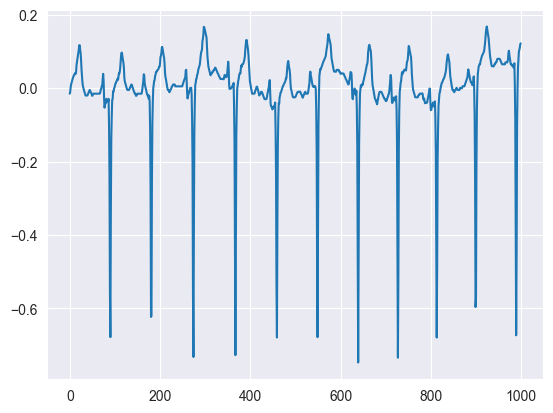

In [81]:
plt.plot(e[0,6].detach().numpy())

In [75]:
e[0,1]

tensor([-0.0350, -0.0520, -0.0780, -0.0730, -0.0770, -0.0800, -0.0800, -0.0780,
        -0.0710, -0.0670, -0.0610, -0.0550, -0.0500, -0.0430, -0.0320, -0.0230,
        -0.0120,  0.0070,  0.0260,  0.0500,  0.0810,  0.1050,  0.1340,  0.1570,
         0.1550,  0.1460,  0.1250,  0.0860,  0.0450,  0.0080, -0.0170, -0.0330,
        -0.0450, -0.0530, -0.0590, -0.0600, -0.0600, -0.0600, -0.0600, -0.0580,
        -0.0550, -0.0520, -0.0500, -0.0470, -0.0450, -0.0490, -0.0500, -0.0500,
        -0.0500, -0.0500, -0.0510, -0.0550, -0.0550, -0.0550, -0.0550, -0.0550,
        -0.0590, -0.0600, -0.0600, -0.0600, -0.0600, -0.0590, -0.0550, -0.0550,
        -0.0530, -0.0490, -0.0510, -0.0460, -0.0400, -0.0350, -0.0300, -0.0240,
        -0.0180,  0.0010,  0.0430,  0.0570,  0.0450,  0.0430,  0.0260, -0.0150,
        -0.0390, -0.0610, -0.0580, -0.0670, -0.0810, -0.0870, -0.0480,  0.0730,
         0.2420,  0.6750,  0.7510,  0.3080,  0.0960,  0.0180, -0.0190, -0.0290,
        -0.0460, -0.0480, -0.0590, -0.05

# RNN1d

In [17]:
from models.nn.rnn1d import RNN1d

rnn1d_model = RNN1d(input_channels=12, num_classes=5)
rnn1d_model.double()
rnn1d_model.eval()



NameError: name 'bn_drop_lin' is not defined